In [1]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
!wget "http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip" -O /content/sample_data/temp.zip
!unzip /content/sample_data/temp.zip

--2020-11-20 03:36:53--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘/content/sample_data/temp.zip’

/content/sample_dat 100%[===================>]  15.43M  19.1MB/s    in 0.8s    

2020-11-20 03:36:54 (19.1 MB/s) - ‘/content/sample_data/temp.zip’ saved [16184794/16184794]

Archive:  /content/sample_data/temp.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  

In [3]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=4438c082bd2c1d2140005d455779ad56eda4018b0dc5afa615f9bef5dfa867ae
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [6]:
# Import Dataset
df = pd.read_csv("/content/question_with_sentiment_v3.csv")
df = df.drop('Topic Label', axis=1)
df.head(10)

,id,company_id,calendar_id,number,executive_id,analyst_id,question,answer,exclude,Clean_text,Named Entity,cluster,compound_score,compound_score_sentiment,sentiment,sentiment_analyser
0,146369,18,163,1,73.0,22,"Thank you, good morning.",Good morning. Good morning.,False,Thank good morning,XYZ Corp,3,0.6597,Positive,"Sentiment(polarity=0.7, subjectivity=0.6000000...","{'neg': 0.0, 'neu': 0.156, 'pos': 0.844, 'comp..."
1,146864,23,176,1,293.0,472,"Hi, good morning, guys. I wanted to ask about ...","Hey, John. This is Clark. I'll take that. Kell...",False,good morning guys wanted about loan growth sho...,NaN,0,0.9337,Positive,"Sentiment(polarity=0.17951940035273364, subjec...","{'neg': 0.0, 'neu': 0.774, 'pos': 0.226, 'comp..."
2,141372,5,23,1,15.0,62,Group,Good morning Joe. Good morning Joe.,False,Group,NaN,1,0.0000,Negative,"Sentiment(polarity=0.0, subjectivity=0.0)","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,147314,39,188,1,175.0,21,Good morning. Just looking to get a little bit...,"Yeah, John how are you doing. It's John here. ...",False,Good morning Just looking little more color de...,NaN,3,0.7964,Positive,"Sentiment(polarity=0.25416666666666665, subjec...","{'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'comp..."
4,144010,33,95,1,218.0,3,Good afternoon. Just wanted to start on the br...,That is correct. Yes. We expect savings o...,False,Good afternoon Just wanted start branch closur...,NaN,4,0.8126,Positive,"Sentiment(polarity=0.32857142857142857, subjec...","{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp..."
5,152964,29,353,1,119.0,136,"Hi, good morning. Paul, I was hoping to just c...","Yeah, that's right. I mean as we said in the p...",False,good morning Paul hoping just clarify outlook ...,NaN,3,0.9324,Positive,"Sentiment(polarity=0.14629629629629629, subjec...","{'neg': 0.05, 'neu': 0.563, 'pos': 0.387, 'com..."
6,141330,12,21,1,54.0,102,"Yeah, thanks. Good morning, everyone. Good to ...","It was the close one, Casey.",False,Yeah thanks Good morning everyone Good hear th...,NaN,3,0.8625,Positive,"Sentiment(polarity=0.575, subjectivity=0.5)","{'neg': 0.133, 'neu': 0.292, 'pos': 0.575, 'co..."
7,153210,27,359,1,112.0,136,"Good morning, Jen and Jamie. Jen, I was wonder...",Sure. So I'll start by saying the most impacte...,False,Good morning Jamie wondering could give some i...,NaN,3,0.6808,Positive,"Sentiment(polarity=0.12499999999999999, subjec...","{'neg': 0.0, 'neu': 0.855, 'pos': 0.145, 'comp..."
8,146975,40,179,1,296.0,146,"Hey, good morning, everybody.","Hey, Steve. Hey, Steve.",False,good morning everybody,NaN,3,0.4404,Neutral,"Sentiment(polarity=0.7, subjectivity=0.6000000...","{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp..."
9,147843,19,205,1,261.0,499,Good morning. So I guess just to follow Joe on...,"Tom, you want to take that? Yes, sure. Eb...",False,Good morning guess just follow your comments a...,NaN,2,0.8625,Positive,"Sentiment(polarity=-0.08000000000000003, subje...","{'neg': 0.062, 'neu': 0.751, 'pos': 0.186, 'co..."


In [7]:
from spacy.lang.en import English
import spacy
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
# spacy_stopwords is a hardcoded set
nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)

Data Cleaning


In [8]:
def text_preprocess(sample_text):
  tokens = tokenizer(sample_text)
  #token_list = []
  lemma_list = []

  for token in tokens:
      if token.lemma_.lower() not in spacy_stopwords:
      #token_list.append(token.text)
          lemma_list.append(token.lemma_)
  #token_list
  text2 = " ".join(lemma_list)

  return text2

In [9]:
df['clean_text_2'] = ''
for i in df.index:
  try:
    df['clean_text_2'][i] = text_preprocess(df['Clean_text'][i])
  except:
    continue

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Clean the input text based on unwanted topic keywords from the inference


In [10]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt.lower()


df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "good morning")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "good afternoon")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "give")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "talk")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "guess")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "book")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "time")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "kind")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "point")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "comment")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "go")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "think")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "know")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "number")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "year")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "look")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "expect")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "question")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "maybe")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "see")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "color")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "see")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "quarter")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "want")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "ing")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "follow")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "beta")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "take")
df['clean_text_2'] = np.vectorize(remove_pattern)(df['clean_text_2'], "guy")

df.head(2)

,id,company_id,calendar_id,number,executive_id,analyst_id,question,answer,exclude,Clean_text,Named Entity,cluster,compound_score,compound_score_sentiment,sentiment,sentiment_analyser,clean_text_2
0,146369,18,163,1,73.0,22,"Thank you, good morning.",Good morning. Good morning.,False,Thank good morning,XYZ Corp,3,0.6597,Positive,"Sentiment(polarity=0.7, subjectivity=0.6000000...","{'neg': 0.0, 'neu': 0.156, 'pos': 0.844, 'comp...",thank
1,146864,23,176,1,293.0,472,"Hi, good morning, guys. I wanted to ask about ...","Hey, John. This is Clark. I'll take that. Kell...",False,good morning guys wanted about loan growth sho...,NaN,0,0.9337,Positive,"Sentiment(polarity=0.17951940035273364, subjec...","{'neg': 0.0, 'neu': 0.774, 'pos': 0.226, 'comp...",s ed loan growth showed od loan growth wonde...


Further cleaning to remove some Junk Patterns using regular expressions


In [11]:
# Convert to list
data = df.clean_text_2.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:10])

['thank ',
 ' s ed loan growth showed od loan growth wonder break little commercial '
 'consumer specifically commercial peers elevated paydowns notice pure basis '
 'balances wonder mortgage like resi mortgage driver loan growth factors',
 'group',
 'od morn little deposit efforts areas types deposits push broad based '
 'increase state rate out continued push exist national platform continue push '
 'product deposit rates higher thanks',
 ' ed start branch closures sounds like million million s target interest '
 'expense based cost saves additional initiatives right',
 ' paul hop clarify out interest income sounds like sequentially second '
 'pressure s mentioned grow half loan deposit growth count favorable',
 'yeah thanks od morn od hear hurricane douglas damage od hear',
 'od morn jamie wonder incremental commercial exposures heavily covid impacted '
 'sectors travel retail help understand types areas incremental commercial '
 'reserve build directed ',
 ' everybody',
 'od morn s

In [12]:
from tqdm import tqdm_notebook as tqdm


In [13]:
doc_list = []
# Iterates through each article in the corpus.
for doc in tqdm(data):
    # Passes that article through the pipeline and adds to a new list.
    pr = nlp(doc)
    doc_list.append(pr)

In [14]:
doc_list[0:10]

[thank ,
  s ed loan growth showed od loan growth wonder break little commercial consumer specifically commercial peers elevated paydowns notice pure basis balances wonder mortgage like resi mortgage driver loan growth factors,
 group,
 od morn little deposit efforts areas types deposits push broad based increase state rate out continued push exist national platform continue push product deposit rates higher thanks,
  ed start branch closures sounds like million million s target interest expense based cost saves additional initiatives right,
  paul hop clarify out interest income sounds like sequentially second pressure s mentioned grow half loan deposit growth count favorable,
 yeah thanks od morn od hear hurricane douglas damage od hear,
 od morn jamie wonder incremental commercial exposures heavily covid impacted sectors travel retail help understand types areas incremental commercial reserve build directed ,
  everybody,
 od morn s multifamily borrower base sense probably uptick re

These pre processing steps will create:


1.   Corpus
2.   Word Vector




In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(doc_list))

print(data_words[:2])

[['thank'], ['ed', 'loan', 'growth', 'showed', 'od', 'loan', 'growth', 'wonder', 'break', 'little', 'commercial', 'consumer', 'specifically', 'commercial', 'peers', 'elevated', 'paydowns', 'notice', 'pure', 'basis', 'balances', 'wonder', 'mortgage', 'like', 'resi', 'mortgage', 'driver', 'loan', 'growth', 'factors']]


In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=500) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=500)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [17]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [18]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[10]]])

['great', 'thanks', 'john', 'ed', 'basis', 'basis', 'recovery', 'margin', 'cuts', 'deposit', 'costs', 'like', 'surprised', 'bigger', 'little', 'terms', 'terms', 'trends', 'margin', 'interest', 'income', 'dollars', 'finance', 'revenue', 'dollars', 'thanks']


In [19]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [20]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:100])

[['thank'], ['growth', 'show', 'loan', 'growth', 'wonder', 'break', 'little', 'commercial', 'consumer', 'specifically', 'commercial', 'peer', 'elevate', 'notice', 'pure', 'basis', 'balance', 'wonder', 'mortgage', 'resi', 'mortgage', 'driver', 'loan', 'growth', 'factor'], ['group'], ['little', 'deposit', 'effort', 'area', 'type', 'deposit', 'push', 'broad', 'base', 'increase', 'state', 'rate', 'continue', 'push', 'exist', 'national', 'platform', 'continue', 'push', 'product', 'deposit', 'rate', 'high', 'thank'], ['branch', 'closure', 'sound', 'target', 'interest', 'expense', 'base', 'cost', 'save', 'additional', 'initiative', 'right'], ['clarify', 'interest', 'income', 'sound', 'sequentially', 'second', 'pressure', 'mention', 'grow', 'half', 'loan', 'deposit', 'growth', 'count', 'favorable'], ['hear'], ['wonder', 'incremental', 'commercial', 'exposure', 'heavily', 'covid', 'impact', 'sector', 'travel', 'retail', 'help', 'understand', 'type', 'area', 'incremental', 'direct'], [], ['base'

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[(0, 1)], [(1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 2), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2)], [(20, 1)], [(0, 1), (10, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 3), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 3), (34, 2), (35, 1), (36, 1)], [(22, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1)], [(9, 1), (11, 1), (25, 1), (43, 1), (46, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)], [(58, 1)], [(4, 1), (19, 1), (21, 1), (36, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1)], [], [(22, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1)]]


Model Build

In [22]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=10,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.409*"thank" + 0.033*"helpful" + 0.025*"understand" + 0.017*"perfect" + '
  '0.016*"pric" + 0.011*"right" + 0.011*"account" + 0.010*"answer" + '
  '0.010*"swap" + 0.009*"bucket"'),
 (1,
  '0.132*"great" + 0.117*"thank" + 0.046*"appreciate" + 0.018*"buyback" + '
  '0.017*"stock" + 0.015*"leave" + 0.010*"repurchase" + 0.008*"share" + '
  '0.008*"deal" + 0.008*"additional"'),
 (2,
  '0.076*"expense" + 0.031*"revenue" + 0.017*"low" + 0.016*"cost" + '
  '0.014*"rate" + 0.012*"mention" + 0.012*"little" + 0.012*"investment" + '
  '0.012*"second" + 0.010*"sense"'),
 (3,
  '0.033*"credit" + 0.027*"loss" + 0.026*"reserve" + 0.023*"charge" + '
  '0.021*"provision" + 0.018*"portfolio" + 0.016*"loan" + 0.013*"risk" + '
  '0.013*"off" + 0.012*"little"'),
 (4,
  '0.065*"rate" + 0.062*"deposit" + 0.035*"basis" + 0.029*"interest" + '
  '0.024*"margin" + 0.019*"yield" + 0.018*"cost" + 0.014*"fund" + 0.014*"term" '
  '+ 0.014*"income"'),
 (5,
  '0.023*"balance" + 0.018*"market" + 0.016*"sheet" +

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.129086 -0.199668       1        1  18.685716
7      0.153329  0.043282       2        1  17.717084
5      0.100133  0.110670       3        1  15.866102
6      0.078290  0.129038       4        1  14.316410
3      0.100354  0.109079       5        1  10.604790
2      0.098916 -0.186524       6        1  10.472881
1     -0.302259  0.060338       7        1   6.745163
0     -0.357850 -0.066216       8        1   5.591854, topic_info=        Term         Freq        Total Category  logprob  loglift
0      thank  3628.000000  3628.000000  Default  30.0000  30.0000
9     growth  1871.000000  1871.000000  Default  29.0000  29.0000
96     great  1051.000000  1051.000000  Default  28.0000  28.0000
25   deposit  1371.000000  1371.000000  Default  27.0000  27.0000
41   expense   939.000000   939.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
679   lastly    31.016340   127.658625   Topic8  -5.3588   1.4690
815     real    26.330828    86.673666   Topic8  -5.5225   1.6924
63      help    33.478354   376.304224   Topic8  -5.2824   0.4644
116   market    33.853697   897.275921   Topic8  -5.2712  -0.3935
241     cash    27.117989   186.009057   Topic8  -5.4931   0.9583

[521 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
102       1  0.363833  account
102       3  0.142583  account
102       5  0.147500  account
102       7  0.004917  account
102       8  0.344167  account
...     ...       ...      ...
418       4  0.062019     word
1021      8  0.982553    worry
410       1  0.774521    yield
410       2  0.200595    yield
410       3  0.022288    yield

[970 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 6, 7, 4, 3, 2, 1])

In [23]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#path = /content/sample_data/mallet
mallet_path = "/content/mallet-2.0.8/bin/mallet" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [24]:
# Show Topics
pprint(ldamallet.show_topics(formatted=True))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.162*"growth" + 0.153*"loan" + 0.057*"balance" + 0.033*"sheet" + '
  '0.026*"grow" + 0.025*"strong" + 0.024*"continue" + 0.023*"commercial" + '
  '0.021*"average" + 0.020*"security"'),
 (1,
  '0.052*"business" + 0.046*"impact" + 0.040*"great" + 0.038*"couple" + '
  '0.037*"pretty" + 0.030*"line" + 0.028*"mortgage" + 0.024*"mention" + '
  '0.021*"start" + 0.019*"quick"'),
 (2,
  '0.086*"expense" + 0.037*"revenue" + 0.037*"guidance" + 0.030*"fourth" + '
  '0.027*"target" + 0.027*"forward" + 0.026*"understand" + 0.023*"provision" + '
  '0.022*"low" + 0.021*"half"'),
 (3,
  '0.119*"rate" + 0.110*"deposit" + 0.054*"basis" + 0.051*"margin" + '
  '0.050*"cost" + 0.045*"interest" + 0.038*"yield" + 0.026*"income" + '
  '0.026*"core" + 0.023*"fund"'),
 (4,
  '0.129*"term" + 0.045*"change" + 0.044*"sort" + 0.039*"curious" + '
  '0.032*"thought" + 0.026*"long" + 0.026*"asset" + 0.024*"environment" + '
  '0.022*"earn" + 0.018*"level"'),
 (5,
  '0.063*"market" + 0.041*"capital" + 0.035*"sen

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

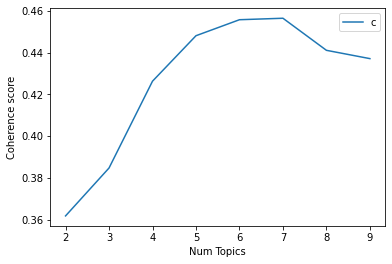

Num Topics = 2  has Coherence Value of 0.361789692
Num Topics = 3  has Coherence Value of 0.3847446818
Num Topics = 4  has Coherence Value of 0.4263357571
Num Topics = 5  has Coherence Value of 0.4481298929
Num Topics = 6  has Coherence Value of 0.4557914913
Num Topics = 7  has Coherence Value of 0.4565006656
Num Topics = 8  has Coherence Value of 0.4411321988
Num Topics = 9  has Coherence Value of 0.437153809


In [26]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 10))  

In [27]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.053*"high" + 0.046*"level" + 0.042*"capital" + 0.033*"understand" + '
  '0.031*"reserve" + 0.029*"loss" + 0.023*"provision" + 0.022*"portfolio" + '
  '0.021*"ratio" + 0.020*"security"'),
 (1,
  '0.076*"great" + 0.056*"credit" + 0.036*"increase" + 0.028*"portfolio" + '
  '0.024*"charge" + 0.023*"mention" + 0.018*"start" + 0.018*"sense" + '
  '0.016*"slide" + 0.015*"today"'),
 (2,
  '0.162*"growth" + 0.153*"loan" + 0.038*"curious" + 0.036*"pretty" + '
  '0.028*"commercial" + 0.028*"mortgage" + 0.025*"strong" + 0.019*"feel" + '
  '0.016*"sense" + 0.016*"ed"'),
 (3,
  '0.062*"market" + 0.051*"business" + 0.045*"bank" + 0.028*"hear" + '
  '0.026*"consumer" + 0.025*"customer" + 0.023*"share" + 0.021*"opportunity" + '
  '0.019*"card" + 0.015*"thought"'),
 (4,
  '0.088*"expense" + 0.038*"revenue" + 0.037*"guidance" + 0.030*"line" + '
  '0.029*"income" + 0.029*"sort" + 0.026*"base" + 0.022*"benefit" + '
  '0.020*"relate" + 0.019*"investment"'),
 (5,
  '0.111*"deposit" + 0.055*"basis" 

INference Code:
Prediction and Mapping your Topic to TEXT

Pass your cleaned data to format_topics_sentences Function


In [31]:
import pickle

pickle.dump(optimal_model,open('/content/mallet_model','wb'))


In [35]:
with open('/content/mallet_model', 'rb') as f:
    optimal_model_loaded = pickle.load(f)

In [36]:
model_topics = optimal_model_loaded.show_topics(formatted=True)
pprint(optimal_model_loaded.print_topics(num_words=10))

[(0,
  '0.053*"high" + 0.046*"level" + 0.042*"capital" + 0.033*"understand" + '
  '0.031*"reserve" + 0.029*"loss" + 0.023*"provision" + 0.022*"portfolio" + '
  '0.021*"ratio" + 0.020*"security"'),
 (1,
  '0.076*"great" + 0.056*"credit" + 0.036*"increase" + 0.028*"portfolio" + '
  '0.024*"charge" + 0.023*"mention" + 0.018*"start" + 0.018*"sense" + '
  '0.016*"slide" + 0.015*"today"'),
 (2,
  '0.162*"growth" + 0.153*"loan" + 0.038*"curious" + 0.036*"pretty" + '
  '0.028*"commercial" + 0.028*"mortgage" + 0.025*"strong" + 0.019*"feel" + '
  '0.016*"sense" + 0.016*"ed"'),
 (3,
  '0.062*"market" + 0.051*"business" + 0.045*"bank" + 0.028*"hear" + '
  '0.026*"consumer" + 0.025*"customer" + 0.023*"share" + 0.021*"opportunity" + '
  '0.019*"card" + 0.015*"thought"'),
 (4,
  '0.088*"expense" + 0.038*"revenue" + 0.037*"guidance" + 0.030*"line" + '
  '0.029*"income" + 0.029*"sort" + 0.026*"base" + 0.022*"benefit" + '
  '0.020*"relate" + 0.019*"investment"'),
 (5,
  '0.111*"deposit" + 0.055*"basis" 

In [28]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1250,"high, level, capital, understand, reserve, los...",thank
1,1,2.0,0.2596,"growth, loan, curious, pretty, commercial, mor...",s ed loan growth showed od loan growth wonder...
2,2,7.0,0.1422,"term, helpful, ation, target, long, risk, rang...",group
3,3,3.0,0.1995,"market, business, bank, hear, consumer, custom...",od morn little deposit efforts areas types dep...
4,4,4.0,0.1990,"expense, revenue, guidance, line, income, sort...",ed start branch closures sounds like million ...
5,5,5.0,0.1758,"deposit, basis, balance, margin, cost, interes...",paul hop clarify out interest income sounds l...
6,6,3.0,0.1422,"market, business, bank, hear, consumer, custom...",yeah thanks od morn od hear hurricane douglas ...
7,7,1.0,0.1445,"great, credit, increase, portfolio, charge, me...",od morn jamie wonder incremental commercial ex...
8,8,0.0,0.1250,"high, level, capital, understand, reserve, los...",everybody
9,9,1.0,0.1776,"great, credit, increase, portfolio, charge, me...",od morn s multifamily borrower base sense prob...


In [29]:
df_dominant_topic.to_csv("/content/df_with_dominant_topic.csv")